In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from math import sqrt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [2]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, root_dir, labels, mode = 'train'):
        self.dataframe = df
        self.root_dir = root_dir
        self.labels = labels
        if mode == 'train':
            self.transform  = transforms.Compose([
                transforms.CenterCrop((1000, 1000)),
                transforms.Resize((300, 300)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean = [0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225])])
        else:
            self.transform = transforms.Compose([
                transforms.CenterCrop((1000, 1000)),
                transforms.Resize((300, 300)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.225, 0.225, 0.225])])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.dataframe[idx]
        image = Image.open(img_name) 
        image = image.convert("RGB")
        image = self.transform(image)
        label = int(self.labels[idx])

        return image, label

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # [32, 150, 150]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # [64, 75, 75]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # [128, 38, 38]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# [256, 19, 19]
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),# [512, 10, 10]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512*10*10, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512*10*10),
            nn.Unflatten(1, (512, 10, 10)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


In [9]:
csv_file = 'CSV Files/bleeding.csv'
bleeding_df = pd.read_csv(csv_file)
bleeding_df = bleeding_df[~bleeding_df['id'].str.contains('.ipynb_checkpoints', na=False)]

In [10]:
from sklearn.model_selection import train_test_split

# Example
X = [[1, 2], [3, 4], [5, 6], [7, 8]]  # Features
y = [0, 1, 0, 1]  # Labels

# Split data into 75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(bleeding_df['id'].fillna(0), bleeding_df['fish id'].fillna(0), test_size=0.25, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (87,)
X_test: (29,)
y_train: (87,)
y_test: (29,)


In [11]:
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

def train_autoencoder(model, train_loader, val_loader, num_epochs=50, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    best_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            
            optimizer.zero_grad()
            recon = model(data)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon = model(data)
                loss = criterion(recon, data)
                val_loss += loss.item()
        
        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_autoencoder.pth")
        
        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def extract_latent_vectors(model, dataloader):
    device = next(model.parameters()).device
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)
            latent = model.encoder(data)
            latent_vectors.append(latent.cpu().numpy())
            labels.append(label.numpy())
    
    return np.concatenate(latent_vectors), np.concatenate(labels)

def cluster_latent_vectors(latent_vectors, true_labels, n_clusters=10):
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_vectors)
    
    # Evaluation metrics
    silhouette = silhouette_score(latent_vectors, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    
    print(f"Clustering Results:")
    print(f" - Silhouette Score: {silhouette:.4f}")
    print(f" - Adjusted Rand Index: {ari:.4f}")
    
    return cluster_labels

In [12]:
model = Autoencoder(latent_dim=128)

# Create datasets and dataloaders
train_dataset = CustomDataset(X_train, 'FishDiseaseZHAW/BleedingVSBloodCirculation', y_train, mode='train')
val_dataset = CustomDataset(X_test, 'FishDiseaseZHAW/BleedingVSBloodCirculation', y_test, mode='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Train the model
train_losses, val_losses = train_autoencoder(model, train_loader, val_loader, num_epochs=50)

# Extract latent vectors for clustering
full_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
latent_vectors, true_labels = extract_latent_vectors(model, full_loader)

# Perform clustering
cluster_labels = cluster_latent_vectors(latent_vectors, true_labels, n_clusters=10)


Epoch: 1/50 | Train Loss: 0.6212 | Val Loss: 0.5795
Epoch: 2/50 | Train Loss: 0.5687 | Val Loss: 0.4499
Epoch: 3/50 | Train Loss: 0.4166 | Val Loss: 0.3476
Epoch: 4/50 | Train Loss: 0.3498 | Val Loss: 0.3355
Epoch: 5/50 | Train Loss: 0.3347 | Val Loss: 0.3257
Epoch: 6/50 | Train Loss: 0.3294 | Val Loss: 0.3253
Epoch: 7/50 | Train Loss: 0.3298 | Val Loss: 0.3251
Epoch: 8/50 | Train Loss: 0.3320 | Val Loss: 0.3248
Epoch: 9/50 | Train Loss: 0.3309 | Val Loss: 0.3187
Epoch: 10/50 | Train Loss: 0.3197 | Val Loss: 0.3041
Epoch: 11/50 | Train Loss: 0.3100 | Val Loss: 0.3024
Epoch: 12/50 | Train Loss: 0.3086 | Val Loss: 0.3022
Epoch: 13/50 | Train Loss: 0.3117 | Val Loss: 0.2971
Epoch: 14/50 | Train Loss: 0.2933 | Val Loss: 0.2843
Epoch: 15/50 | Train Loss: 0.2905 | Val Loss: 0.2789
Epoch: 16/50 | Train Loss: 0.2890 | Val Loss: 0.2787
Epoch: 17/50 | Train Loss: 0.2855 | Val Loss: 0.2783
Epoch: 18/50 | Train Loss: 0.2873 | Val Loss: 0.2780
Epoch: 19/50 | Train Loss: 0.2836 | Val Loss: 0.2768
Ep

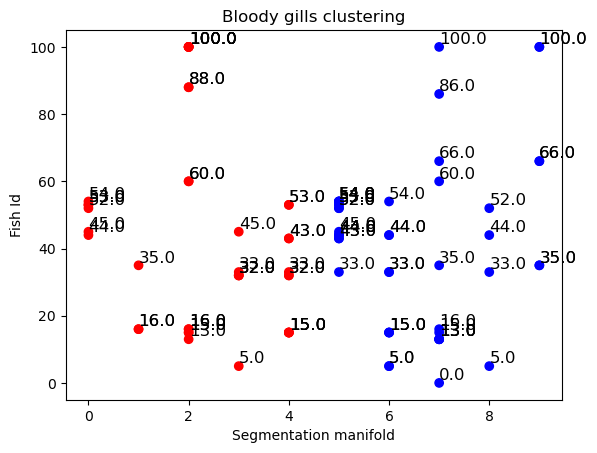

In [67]:
colors = ['blue' if x > 4.5 else 'red' for x in cluster_labels]
plt.scatter(cluster_labels, y_train, c=colors)

# Add text labels next to each scatter point
for i in range(len(cluster_labels)):
    plt.text(cluster_labels[i], y_train[i], str(y_train[i]), fontsize=12, ha='left', va='bottom')

# Turn off the grid and axes
plt.grid(False)
# plt.axis('off')
plt.xlabel('Segmentation manifold')
plt.ylabel('Fish Id')
plt.title('Bloody gills clustering')

# Show the plot
plt.show()

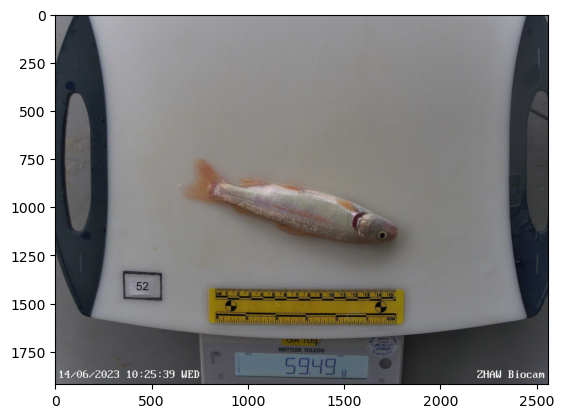

In [54]:
import cv2
path = bleeding_df[bleeding_df['fish id'] == 52]['id'][50]
img = cv2.imread(path)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image)

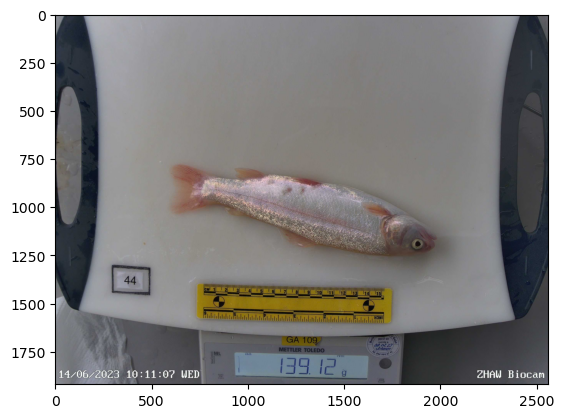

In [62]:
import cv2
path = bleeding_df[bleeding_df['fish id'] == 44]['id'][8]
img = cv2.imread(path)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image)
